In [11]:
import pandas as pd
import glob
import numpy as np

In [12]:
import matplotlib.pyplot as plt 

## Combining multiple data files (which all must have the same columns)

We can use `glob` to select all files in the data directory. Here the `*` character stands for 'match anything' (and not multiplication, as it is used elsewhere). This line says to get all the files ending in `.csv` that are in any subdirectory of `data/`. 

In [13]:
data_files = glob.glob("data/2021/*.csv")

## Combining the files together

In [14]:
all_files = []
for file in data_files:
    data_temp = pd.read_csv(file)
    all_files.append(data_temp)

In [15]:
data = pd.concat(all_files)

We also want to rename those columns into things that remove the newlines (or `\n`)

In [16]:
data.columns = ['year', 'location', 'first_name', 'last_name', 'title', 'total_pay', 'regular_pay', 'overtime_pay', 'other_pay']

## Counting the number of workers in each location:
We will do a `groupby` with the location column. After the groupby function, you should usually specify which column you want to work with. We want to count the number of workers in each location, so it doesn't matter which column you want to work with here. It will matter when we do mean, median, or total salary later, we have to specify which salary column we want to use.

We can sort the list smallest to largest:

We can visualize a horizontal bar graph by adding `.plot(kind='barh')` to the sorted table:

<AxesSubplot:ylabel='location'>

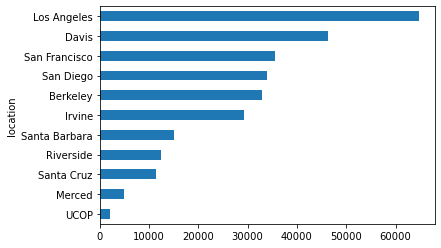

In [17]:
data.groupby('location')['year'].count().sort_values().plot(kind='barh')

# Cleaning data
## Classifying titles
One problem is that there are many different specialized titles, and the payroll system doesn't make it easy to tell them apart. At UCSD we have [this site](http://hr.ucsd.edu/tpp/) which you can use to lookup payroll titles and see a description.

We will create a new function to classify these:

In [18]:
def classify_title(text):
    text = str(text).upper()
    
    if "POSTDOC" in text:
        return "POSTDOC"
    elif "GSHIP" in text or "GSR" in text:
        return "GRAD"
    elif "LECT" in text or "TEACHER" in text:
        return "LECTURER"
    elif "DEAN" in text and "ASST" not in text and "AST" not in text:
        return "EXEC"
    elif "VC" in text and "ASST" not in text and "AST" not in text and 'SVC' not in text:
        return "EXEC"
    elif "CHAN" in text and "ASST" not in text and "AST" not in text:
        return "EXEC"
    elif "CMO MED CTR" in text:
        return "EXEC"
    elif "PROF" in text:
        return "PROF"
    elif "STDT" in text or "MGR" in text or "AST" in text or "SRA" in text or "ADMIN" in text or "SPEC" in text or "HR" in text or "ANL" in text:
        return "ADMIN"
    elif "NURSE" in text or "PHYS" in text or "PAT" in text or "MED C" in text or "CLIN" in text or "PHARM" in text:
        return "MEDICAL-OTHER"
    else:
        return "UNKNOWN"

### Using `apply` to classify all titles in the dataset

We want to create a new column called `title_class`. This is where we will save the results of applying that function to the `title` column in our original dataset:

In [23]:
data['title_class'] = data['title'].apply(classify_title)
data

,year,location,first_name,last_name,title,total_pay,regular_pay,overtime_pay,other_pay,title_class
0,2021,Davis,*****,*****,POSTDOC-EMPLOYEE,76125.0,76125.0,0.0,0.0,POSTDOC
1,2021,Davis,*****,*****,GSR-FULL FEE REM,19440.0,19440.0,0.0,0.0,GRAD
2,2021,Davis,*****,*****,STDT 4,1110.0,1110.0,0.0,0.0,ADMIN
3,2021,Davis,*****,*****,GSR-FULL FEE REM,7539.0,7539.0,0.0,0.0,GRAD
4,2021,Davis,*****,*****,GSR-FULL FEE REM,33365.0,33365.0,0.0,0.0,GRAD
...,...,...,...,...,...,...,...,...,...,...
11349,2021,Santa Cruz,AMY,ZUROEVESTE,BLANK AST 3,50745.0,50445.0,0.0,300.0,ADMIN
11350,2021,Santa Cruz,THOMAS,ZUUR,AUTO EQUIP OPR SR,39810.0,38134.0,458.0,1217.0,UNKNOWN
11351,2021,Santa Cruz,ANN,ZWEIG,BIOINFORMATICS MGR 1,135039.0,134439.0,0.0,600.0,ADMIN
11352,2021,Santa Cruz,JUAN,ZWOLINSKI,ASSOC RES-FY-NON REP,113925.0,113925.0,0.0,0.0,UNKNOWN


## Removing those whose total pay for a year is less than $15,000

Data cleaning is full of political and value choices!


In [24]:
data_cleaned = data.query("total_pay > 15000")

In [25]:
data_cleaned['title_class'].value_counts()

ADMIN            59542
UNKNOWN          41199
MEDICAL-OTHER    36915
PROF             20305
GRAD             20211
POSTDOC           6295
LECTURER          5008
EXEC               265
Name: title_class, dtype: int64

We are also going to save a version of the 2021 dataset that is not filtered out, because later we will look at the total money spent on the system:

## Pivot tables

For a pivot table, you give it a dataset and tell it what a summarized table should look like. You specify the rows (or index), the columns, the values, and how you want to summarize the data. So we want our rows/index to be the title_class, the columns to be the location, and the values to be total_pay. You should also specify the `aggfunc` or aggregation function: should it give you the mean (average), median, sum (total) of all of those values?

In [ ]:
pivot_median_total_by_loc = pd.pivot_table(data_cleaned, index='title_class', columns='location', values='total_pay', aggfunc='median')
pivot_median_total_by_loc

In [ ]:
median_grad_stipend = pivot_median_total_by_loc.query("title_class=='GRAD'").T.dropna()
median_grad_stipend.columns = ['median_salary']

In [ ]:
median_grad_stipend

## __For lab: make a copy of [this Google Sheet](https://docs.google.com/spreadsheets/d/1_414HaUoE2rqReIYNFrR3r6N3-pwzVkDPt85N3GHuCU/edit#gid=484715097), add what you think you might be able to pay for rent in these cities, download as excel file, and upload to the data folder in week_8__

## Be sure to _NOT_ enter your values with commas, enter just numbers like the Berkeley example

In [ ]:
rents = pd.read_excel("data/rent.xlsx")
rents

In [ ]:
merged_data = pd.merge(left=median_grad_stipend, right=rents, on='location', how='inner')
merged_data

In [ ]:
merged_data['annual_rent'] = merged_data['monthly_rent'] * 12
merged_data

In [ ]:
merged_data['rent_burden'] = (merged_data['annual_rent']/merged_data['median_salary']) * 100

In [ ]:
merged_data.index = merged_data.location

In [ ]:
merged_data['rent_burden'].plot(kind='bar', figsize=(6,4), ylabel="Percent of income spent on rent")
plt.savefig('rent_burden.png', bbox_inches='tight')